In [51]:
import pandas as pd, numpy as np
from datetime import datetime
pd.set_option('max_colwidth',200)
# import yfinance as yf
import tushare as ts
import time, urllib
ts.set_token('2f31c3932ead9fcc3830879132cc3ec8df3566550f711889d4a30f67')
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

# 读取数据

In [52]:
ch_etfs_df = pd.read_csv("/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/"+"CH_ETFs.csv")
ch_etfs_df.dropna(inplace = True)
ch_etfs_df['基金规模\n[单位] 元'] = ch_etfs_df['基金规模\n[单位] 元'].apply(lambda x: float(x.replace(",","")))
ch_etfs_df['机构投资者持有份额\n[报告期] 2019中报\n[单位] 份'] = ch_etfs_df['机构投资者持有份额\n[报告期] 2019中报\n[单位] 份'].apply(lambda x: float(x.replace(",","")))
ch_etfs_df.sort_values("基金规模\n[单位] 元", ascending=False, inplace =True)
ch_etfs_df = ch_etfs_df.head(50)
ch_etfs = ch_etfs_df.copy()
ch_etfs['code'] =ch_etfs['证券代码'].apply(lambda x: str(x)[:6])
ch_etfs_ticker = list(ch_etfs['code'].unique())
# Add the sp500 etf
etf_tickers = ['513500']+ch_etfs_ticker

In [53]:
len(set(etf_tickers))

51

# 1. Correlation Analysis for ETFs and Filter Targets

- Function 1. Plot correlation matrix heatmap of multiple assets from: to-be-made func: etf_corr_heatmap(ticker, list, path, price_col, date_col)

- Function 2. Filter assets with lowest correlations among them

In [54]:
# This part is for generating correlation heatmaps

today = str(datetime.now().date())
start = '2010-01-01'
end = today

ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
ticker_df_list = []
for ticker in etf_tickers:
    print("Reading ETF: ", ticker)
    try:
        ticker_df = pd.read_csv(ch_db_path+ticker+".csv")
        ticker_df = ticker_df.sort_values('date')
        ticker_df = ticker_df[['date','close','code']]
        ticker_df['pct_chg'] = ticker_df['close'].pct_change()
        ticker_df = ticker_df[['date', 'pct_chg']].dropna()
        ticker_df.columns = ['date',ticker]
        ticker_df['date'] = pd.to_datetime(ticker_df['date'])
    #     stock.set_index('date', inplace=True)
        ticker_df_list.append(ticker_df)
#     except FileNotFoundError:
#         print("Does not have ETF {}, start downloading now...".format(ticker))
#         data = GetHistoryData(ticker, start, today)
#         data.to_csv(ch_db_path+ticker+".csv", index = False)
#         print("ETF {} downloaded.".format(ticker))
    except:
        pass

Reading ETF:  513500
Reading ETF:  510500
Reading ETF:  510050
Reading ETF:  510300
Reading ETF:  510330
Reading ETF:  159919
Reading ETF:  510180
Reading ETF:  159915
Reading ETF:  512960
Reading ETF:  512950
Reading ETF:  510810
Reading ETF:  512880
Reading ETF:  510900
Reading ETF:  518880
Reading ETF:  510310
Reading ETF:  159901
Reading ETF:  512500
Reading ETF:  159920
Reading ETF:  159949
Reading ETF:  510230
Reading ETF:  510850
Reading ETF:  159959
Reading ETF:  511030
Reading ETF:  510390
Reading ETF:  510510
Reading ETF:  510380
Reading ETF:  512000
Reading ETF:  159962
Reading ETF:  510360
Reading ETF:  159928
Reading ETF:  159922
Reading ETF:  510880
Reading ETF:  159938
Reading ETF:  510590
Reading ETF:  159902
Reading ETF:  512660
Reading ETF:  512070
Reading ETF:  159939
Reading ETF:  511220
Reading ETF:  512900
Reading ETF:  512380
Reading ETF:  512800
Reading ETF:  512580
Reading ETF:  159905
Reading ETF:  159952
Reading ETF:  159910
Reading ETF:  511270
Reading ETF: 

In [55]:
# 一次性merge多个pct_chg
from functools import reduce

# 先为之后使用reduce铺路：创造一个merge的函数：
def merge_df(df1, df2):
    df1.sort_values('date', inplace = True)
    merged = df1.merge(df2, on = 'date', how = 'outer')
    merged.sort_values('date', inplace = True)
    return merged

# 重要知识点：reduce
# stock_list里都是一个个dataframe
merged_all = reduce(merge_df, ticker_df_list)
merged_all.set_index('date', inplace=True)
merged_all.dropna(how="all", axis = 1, inplace = True)

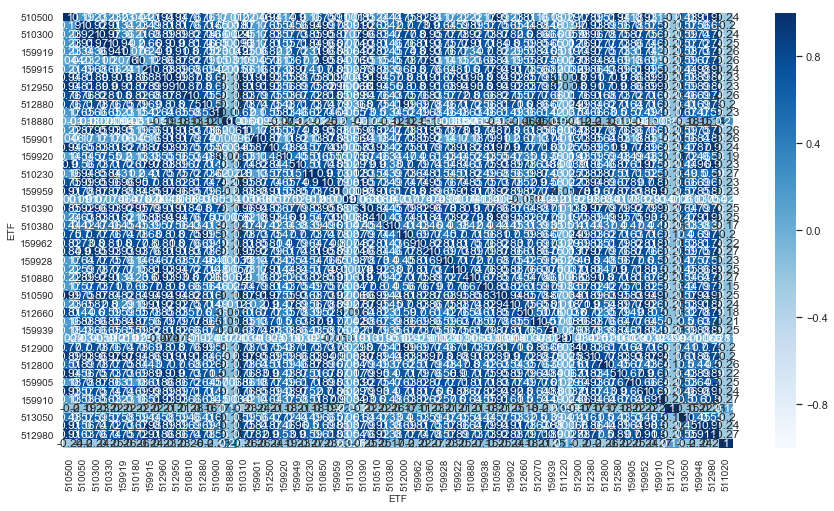

In [56]:
# 最后一步：plot heatmap:
fig, ax = plt.subplots(figsize = (15, 8))
sns.heatmap(merged_all.corr()[abs(merged_all.corr())>-2], ax = ax, cmap = 'Blues', vmax = 1.0, vmin = -1.0, annot=True)
plt.xlabel('ETF', fontsize = 10)
plt.ylabel('ETF', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

In [57]:
# Create ETFs' correlation matrix dataframe
merged_all_corr = merged_all.corr()
merged_all_corr_abs = abs(merged_all_corr)

corr_mean_dict = {}

for row in merged_all_corr_abs.iterrows():
    row_list = list(row)
    print(row_list[0])
    print(np.mean(row_list[1]))
    corr_mean_dict[row_list[0]] = np.mean(row_list[1])
    print("========")

510500
0.4798578666443368
510050
0.6159509822917273
510300
0.6866562440435063
510330
0.6877497061298965
159919
0.5842140155175948
510180
0.486140850423146
159915
0.6189800101048845
512960
0.775284837654523
512950
0.7770919257990225
510810
0.679079467139771
512880
0.6584031573096033
510900
0.49556011286271134
518880
0.10674214060600029
510310
0.694673525675818
159901
0.48498119211532964
512500
0.7189675331981101
159920
0.4484518880691341
159949
0.6791692644267954
510230
0.5680210284446097
510850
0.7287949956138913
159959
0.7572719883764867
511030
0.06670442190823678
510390
0.7667845426455285
510510
0.6804426733461729
510380
0.4074091418437939
512000
0.6539675011044721
159962
0.6868449696519471
510360
0.7456175682216766
159928
0.5541499078387228
159922
0.6505653041613432
510880
0.6514808714575058
159938
0.6207959964028769
510590
0.765775332472547
159902
0.6675957021913882
512660
0.5798178556570351
512070
0.6415631330028934
159939
0.6162699619248618
511220
0.045195313194353125
512900
0.65

In [58]:
corr_mean_df = pd.DataFrame()
corr_mean_df['etf'] = corr_mean_dict.keys()
corr_mean_df['abs_corr_mean'] = corr_mean_dict.values()
corr_mean_df_10_etf = corr_mean_df.sort_values("abs_corr_mean", ascending=True)

In [59]:
corr_mean_df_10_etf.head(20)

,etf,abs_corr_mean
11,511220,0.045195
42,511030,0.066704
14,518880,0.106742
5,511270,0.213726
13,511020,0.241293
22,510380,0.407409
29,159920,0.448452
10,510500,0.479858
24,159901,0.484981
27,513050,0.485334


In [60]:
selected_10_etf_list = list(corr_mean_df_10_etf['etf'])[:20]

In [61]:
selected_10_etf_list

['511220',
 '511030',
 '518880',
 '511270',
 '511020',
 '510380',
 '159920',
 '510500',
 '159901',
 '513050',
 '510180',
 '510900',
 '159928',
 '159910',
 '510230',
 '512800',
 '512660',
 '159919',
 '510050',
 '159939']

# 2. Select Target Data from Database Folder

In [62]:
ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
csv_path = ch_db_path+"*.csv"
files = glob.glob(csv_path)

In [63]:
tickers_data = []
for ticker in selected_10_etf_list:
    print("Reading: ", ticker)
    ticker_df = pd.read_csv(ch_db_path+ticker+".csv")
    tickers_data.append(ticker_df)

Reading:  511220
Reading:  511030
Reading:  518880
Reading:  511270
Reading:  511020
Reading:  510380
Reading:  159920
Reading:  510500
Reading:  159901
Reading:  513050
Reading:  510180
Reading:  510900
Reading:  159928
Reading:  159910
Reading:  510230
Reading:  512800
Reading:  512660
Reading:  159919
Reading:  510050
Reading:  159939


In [64]:
tickers_data_concated = pd.concat(tickers_data)
tickers_data_concated.reset_index(inplace=True)
del tickers_data_concated['index']

In [65]:
tickers_data_concated

,date,open,close,high,low,volume,code
0,2014-12-16,96.000,94.930,96.000,94.902,1652.0,511220
1,2014-12-17,94.931,94.911,95.038,94.602,1462.0,511220
2,2014-12-18,85.911,94.131,94.801,85.911,926.0,511220
3,2014-12-19,94.000,94.130,94.299,93.500,426.0,511220
4,2014-12-22,93.001,93.475,93.980,92.004,16.0,511220
...,...,...,...,...,...,...,...
27027,2019-12-25,1.151,1.170,1.175,1.147,540909.0,159939
27028,2019-12-26,1.169,1.175,1.175,1.161,447276.0,159939
27029,2019-12-27,1.176,1.150,1.182,1.148,512041.0,159939
27030,2019-12-30,1.144,1.154,1.156,1.120,462869.0,159939


# 2. Technical Analysis Building & Signal Generation

In [66]:
def MACD(df, n_fast, n_slow, n_macd): # n_fast = 12, n_slow = 26
    """
    
    http://stockcharts.com/docs/doku.php?id=scans:indicators

    """
    """
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df['close'].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df['close'].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df['MACD_Diff'] = MACD
    df['MACD_Diff_EMA'] = MACDsign
    df['MACD'] = MACDdiff
    df['SIGNAL_STATUS'] = df['MACD'].apply(lambda x: "多头状态" if x>0 else ("空头状态" if x<0 else "无信号状态"))
#     return MACD, MACDsign, MACDdiff
    return df

In [67]:
signal_record = []
signal_data = []
for ticker in selected_10_etf_list:
    print("Calculating Signal for: ", ticker)
    try:
        single_ticker_df = tickers_data_concated[tickers_data_concated['code']==float(ticker)]
        signal_df = MACD(single_ticker_df, 12, 26, 9)
        last_signal = signal_df[['code','SIGNAL_STATUS']].values[-1]
        signal_data.append(signal_df)
        signal_record.append(last_signal)
    except:
        pass

Calculating Signal for:  511220
Calculating Signal for:  511030
Calculating Signal for:  518880
Calculating Signal for:  511270
Calculating Signal for:  511020
Calculating Signal for:  510380
Calculating Signal for:  159920
Calculating Signal for:  510500
Calculating Signal for:  159901
Calculating Signal for:  513050
Calculating Signal for:  510180
Calculating Signal for:  510900
Calculating Signal for:  159928
Calculating Signal for:  159910
Calculating Signal for:  510230
Calculating Signal for:  512800
Calculating Signal for:  512660
Calculating Signal for:  159919
Calculating Signal for:  510050
Calculating Signal for:  159939


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [68]:
signal_data_df = pd.concat(signal_data)
signal_data_df

,date,open,close,high,low,volume,code,MACD_Diff,MACD_Diff_EMA,MACD,SIGNAL_STATUS
0,2014-12-16,96.000,94.930,96.000,94.902,1652.0,511220,NaN,NaN,NaN,无信号状态
1,2014-12-17,94.931,94.911,95.038,94.602,1462.0,511220,NaN,NaN,NaN,无信号状态
2,2014-12-18,85.911,94.131,94.801,85.911,926.0,511220,NaN,NaN,NaN,无信号状态
3,2014-12-19,94.000,94.130,94.299,93.500,426.0,511220,NaN,NaN,NaN,无信号状态
4,2014-12-22,93.001,93.475,93.980,92.004,16.0,511220,NaN,NaN,NaN,无信号状态
...,...,...,...,...,...,...,...,...,...,...,...
27027,2019-12-25,1.151,1.170,1.175,1.147,540909.0,159939,0.024310,0.022625,0.001685,多头状态
27028,2019-12-26,1.169,1.175,1.175,1.161,447276.0,159939,0.024672,0.023035,0.001637,多头状态
27029,2019-12-27,1.176,1.150,1.182,1.148,512041.0,159939,0.022679,0.022964,-0.000284,空头状态
27030,2019-12-30,1.144,1.154,1.156,1.120,462869.0,159939,0.021179,0.022607,-0.001428,空头状态


In [69]:
def make_numeric_signals(series):
    for item in series:
        print(item)
        if item =="多":
            return 1
        elif item =="空":
            return -1
        else:
            return 0

In [70]:
signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: make_numeric_signals(x))

无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
多
多
多
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多


空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
空
空
空
多
多
空
空
多
多
多
多
多
多
多
多
多
多
多
多


空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
空
空
空
空
空
空
空
空
空
空
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多


多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
空
空
空
空
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
多
空
空
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
多
多
多
多
多
空
空
空
空
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多


空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
空
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
无
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多


空
空
空
空
空
空
空
空
空
空
多
多
多
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
空
空
空
空
空
空
空
空
空
空
空
空
空
空
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多
多


In [71]:
signal_data_df.tail(10)

,date,open,close,high,low,volume,code,MACD_Diff,MACD_Diff_EMA,MACD,SIGNAL_STATUS,SIGNAL_DIRECTION
27022,2019-12-18,1.190,1.190,1.203,1.184,681974.0,159939,0.027894,0.016239,0.011654,多头状态,1
27023,2019-12-19,1.189,1.183,1.193,1.175,497972.0,159939,0.029621,0.018916,0.010705,多头状态,1
27024,2019-12-20,1.173,1.160,1.188,1.160,733059.0,159939,0.028802,0.020893,0.007909,多头状态,1
27025,2019-12-23,1.148,1.127,1.155,1.127,738369.0,159939,0.025199,0.021754,0.003445,多头状态,1
27026,2019-12-24,1.128,1.151,1.152,1.128,500444.0,159939,0.024004,0.022204,0.001800,多头状态,1
27027,2019-12-25,1.151,1.170,1.175,1.147,540909.0,159939,0.024310,0.022625,0.001685,多头状态,1
27028,2019-12-26,1.169,1.175,1.175,1.161,447276.0,159939,0.024672,0.023035,0.001637,多头状态,1
27029,2019-12-27,1.176,1.150,1.182,1.148,512041.0,159939,0.022679,0.022964,-0.000284,空头状态,-1
27030,2019-12-30,1.144,1.154,1.156,1.120,462869.0,159939,0.021179,0.022607,-0.001428,空头状态,-1
27031,2019-12-31,1.150,1.157,1.164,1.145,404124.0,159939,0.020002,0.022086,-0.002084,空头状态,-1


In [72]:
signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby(['code'])['SIGNAL_DIRECTION'].diff()

In [73]:
signal_data_df.tail(2)

,date,open,close,high,low,volume,code,MACD_Diff,MACD_Diff_EMA,MACD,SIGNAL_STATUS,SIGNAL_DIRECTION,SIGNAL_DIRECTION_DIFF
27030,2019-12-30,1.144,1.154,1.156,1.120,462869.0,159939,0.021179,0.022607,-0.001428,空头状态,-1,0.0
27031,2019-12-31,1.150,1.157,1.164,1.145,404124.0,159939,0.020002,0.022086,-0.002084,空头状态,-1,0.0


In [74]:
# signal_data_df['SIGNAL_DIFF'] = signal_data_df.groupby(['code'])['MACD'].diff()
signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
# signal_data_df['SIGNAL_ACTION'] = signal_data_df.groupby(['code'].apply(lambda x: "LONG" if ))

In [75]:
signal_data_df.groupby(['code'])[['date','code','SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)

,date,code,SIGNAL_STATUS,SIGNAL_ACTION
1221,2019-12-31,511220,多头状态,NO CHANGE
1405,2019-12-31,511030,多头状态,NO CHANGE
2974,2019-12-31,518880,多头状态,NO CHANGE
3244,2019-12-31,511270,多头状态,LONG
3437,2019-12-31,511020,多头状态,NO CHANGE
3835,2019-12-31,510380,多头状态,NO CHANGE
5588,2019-12-31,159920,多头状态,NO CHANGE
7243,2019-12-31,510500,多头状态,NO CHANGE
9672,2019-12-31,159901,多头状态,NO CHANGE
10392,2019-12-31,513050,多头状态,NO CHANGE


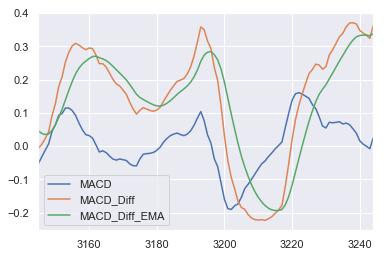

In [78]:
signal_data_df[signal_data_df['code']==511270][['MACD','MACD_Diff','MACD_Diff_EMA']].tail(100).plot()

# 2. ETF plotting

In [23]:
# This part is for looking up charts and market data
ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
list_10_etfs_to_concat = []
for ticker in selected_10_etf_list:
    print("Reading ETF: ", ticker)
    try:
        ticker_df = pd.read_csv(ch_db_path+ticker+".csv")
        list_10_etfs_to_concat.append(ticker_df)
#     except FileNotFoundError:
#         print("Does not have ETF {}, start downloading now...".format(ticker))
#         data = GetHistoryData(ticker, start, today)
#         data.to_csv(ch_db_path+ticker+".csv", index = False)
#         print("ETF {} downloaded.".format(ticker))
    except:
        pass

df_10_etfs = pd.concat(list_10_etfs_to_concat)

Reading ETF:  511220
Reading ETF:  511030
Reading ETF:  518880
Reading ETF:  511270
Reading ETF:  511020
Reading ETF:  510380
Reading ETF:  159920
Reading ETF:  510500
Reading ETF:  159901
Reading ETF:  510180


In [24]:
df_10_etfs.tail()

,date,open,close,high,low,volume,code
2422,2019-12-23,3.478,3.435,3.490,3.432,284488.0,510180
2423,2019-12-24,3.450,3.460,3.460,3.436,206568.0,510180
2424,2019-12-25,3.458,3.458,3.463,3.441,263552.0,510180
2425,2019-12-26,3.458,3.480,3.482,3.451,241315.0,510180
2426,2019-12-27,3.481,3.489,3.524,3.481,306505.0,510180


In [25]:
def plot_individual(ticker, df_10_etfs):    
    dt = df_10_etfs[df_10_etfs['code']==ticker]
    y_close = dt['close']
    x_dt = dt['date']
    etf = go.Scatter(
            x = x_dt,
            y = y_close,
    #         mode = 'lines',
            name = str(ticker)
    )
    data_etf = [etf]
    py.iplot(data_etf)

In [26]:
selected_10_etf_list.remove("159901")

In [27]:
selected_10_etf_list

['511220',
 '511030',
 '518880',
 '511270',
 '511020',
 '510380',
 '159920',
 '510500',
 '510180']

In [28]:
def data_to_plot_multiples(df_10_etfs, selected_10_etf_list):
    data_etfs = []
    num = 1
    for ticker in selected_10_etf_list:
        dt = df_10_etfs[df_10_etfs['code']==int(ticker)]
        y_close = dt['close']
        x_dt = dt['date']
        etf = go.Scatter(
                x = x_dt,
                y = y_close,
                name = str(ticker),
                xaxis = 'x{}'.format(num),
                yaxis = 'y{}'.format(num)
        )
        data_etfs.append(etf)
        num+=1
    return data_etfs

In [29]:
data_etfs = data_to_plot_multiples(df_10_etfs, selected_10_etf_list)

layout = go.Layout(
    xaxis=dict(
        domain=[0, 0.3]
    ),
    yaxis=dict(
        domain=[0, 0.3]
    ),
    
    xaxis2=dict(
        domain=[0.35, 0.65],
        anchor='y2'
    ),
    yaxis2=dict(
        domain=[0, 0.3],
        anchor='x2'
    ),
    
    xaxis3=dict(
        domain=[0.7, 1],
        anchor='y3'
    ),
    yaxis3=dict(
        domain=[0, 0.3],
        anchor='x3'
    ),
    
    

    xaxis4=dict(
        domain=[0, 0.3],
        anchor='y4'
    ),
    yaxis4=dict(
        domain=[0.35, 0.65],
        anchor='x4'
    ),
    
    xaxis5=dict(
        domain=[0.35, 0.65],
        anchor='y5'
    ),
    yaxis5=dict(
        domain=[0.35, 0.65],
        anchor='x5'
    ),
    
    xaxis6=dict(
        domain=[0.7, 1],
        anchor='y6'
    ),
    yaxis6=dict(
        domain=[0.35, 0.65],
        anchor='x6'
    ),
    
    
    xaxis7=dict(
        domain=[0, 0.3],
        anchor='y7'
    ),
    yaxis7=dict(
        domain=[0.7, 1],
        anchor='x7'
    ),
    
    xaxis8=dict(
        domain=[0.35, 0.65],
        anchor='y8'
    ),
    yaxis8=dict(
        domain=[0.7, 1],
        anchor='x8'
    ),
    
    xaxis9=dict(
        domain=[0.7, 1],
        anchor='y9'
    ),
    yaxis9=dict(
        domain=[0.7, 1],
        anchor='x9'
    ),
    
)

In [30]:
fig = go.Figure(data=data_etfs, layout=layout)

In [31]:
py.plot(fig, filename='multiple-subplots')

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/plotly/offline/offline.py:526: UserWarning:

Your filename `multiple-subplots` didn't end with .html. Adding .html to the end of your file.



'multiple-subplots.html'

In [120]:
plot(510180)

In [37]:
selected_10_etf_list

['511220',
 '511030',
 '518880',
 '511270',
 '511020',
 '510380',
 '159920',
 '510500',
 '510180']

In [42]:
filtered__info = ch_etfs_df[ch_etfs_df['证券代码'].map(lambda x: x[:6] in selected_10_etf_list)]

In [43]:
filtered__info

,证券代码,证券简称,投资类型(一级分类),投资类型(二级分类),基金规模\n[单位] 元,机构投资者持有份额\n[报告期] 2019中报\n[单位] 份,机构投资者持有比例\n[报告期] 2019中报\n[单位] %,管理费率\n[单位] %,托管费率\n[单位] %,认购费率\n[收费类型] 前端
152,510500.OF,南方中证500ETF,股票型基金,被动指数型基金,4.349555e+10,6.869517e+09,76.03,0.50,0.10,500万份以上 1000元/笔\n100万份以下 1%\n100~300万份 0.6%\n300~500万份 0.3%\n
169,510180.OF,华安上证180ETF,股票型基金,被动指数型基金,1.958375e+10,5.378177e+09,95.37,0.50,0.10,100万份以下 1%\n100~1000万份 0.8%\n1000万份以上 0.5%\n
0,518880.OF,华安黄金ETF,另类投资基金,商品型基金,8.597897e+09,1.167058e+09,65.07,0.50,0.10,"500元/笔,通过基金管理人现金认购本基金份额的养老金客户认购费率。\n100万份以上 1000元/笔\n50万份以下 0.5%\n50~100万份 0.3%\n"
244,159920.OF,华夏恒生ETF,国际(QDII)基金,国际(QDII)股票型基金,5.946218e+09,2.499516e+09,91.04,0.60,0.15,50万份以上 1000元/笔\n50万份以下 0.8%\n
131,511030.OF,平安中债-中高等级公司债利差因子ETF,债券型基金,被动指数型债券基金,5.206926e+09,5.108587e+07,99.99,0.25,0.08,100万份以上 1000元/笔\n50万份以下 0.4%\n50~100万份 0.2%\n
157,510380.OF,国寿安保沪深300ETF,股票型基金,被动指数型基金,4.684516e+09,4.732370e+09,99.82,0.50,0.10,50万份以上 500元/笔\n50万份以下 0.8%\n
129,511220.OF,海富通上证城投债ETF,债券型基金,被动指数型债券基金,1.885463e+09,1.957374e+07,95.07,0.30,0.10,100万份以上 1000元/笔\n50万份以下 0.4%\n50~100万份 0.2%\n
127,511270.OF,海富通上证10年期地方政府债ETF,债券型基金,被动指数型债券基金,1.239962e+09,1.223830e+07,98.80,0.25,0.10,100万份以上 1000元/笔\n50万份以下 0.4%\n50~100万份 0.2%\n
132,511020.OF,平安5-10年期国债活跃券ETF,债券型基金,被动指数型债券基金,1.141506e+09,1.117982e+07,99.80,0.25,0.05,100万份以上 1000元/笔\n50万份以下 0.4%\n50~100万份 0.2%\n


# Plotly application example

https://www.jianshu.com/p/f8423ad5e06e

In [52]:
N = 100
random_x = np.linspace(0,1,N)
random_y0 = np.random.randn(N)+5
random_y1 = np.random.randn(N)
random_y2 = np.random.randn(N)-5

#Create traces
trace0 = go.Scatter(
    x = random_x,
    y = random_y0,
    mode = 'markers',
    name = 'markers'
)
trace1 = go.Scatter(
    x = random_x,
    y = random_y1,
    mode = 'lines+markers',
    name = 'lines+markers'
)
trace2 = go.Scatter(
    x = random_x,
    y = random_y2,
    mode = 'lines',
    name = 'lines'
)
data = [trace0,trace1,trace2]
# py.plot(data)

In [56]:
etf_513500

Scatter({
    'mode': 'lines',
    'name': 'lines',
    'x': array(['2014-01-15', '2014-01-16', '2014-01-17', ..., '2019-12-18',
                '2019-12-19', '2019-12-20'], dtype=object),
    'y': array([0.986, 0.991, 0.987, ..., 2.091, 2.084, 2.097])
})